# Comparison of YOLO und R-CNN for Object Detection

In this notepad, we want to provide some visualization for the usage of YOLO and R-CNN. Therefore, some sample data of the **Formula Student Objects in Context Dataset** (https://www.fsoco-dataset.com/) will be used.

## Preprocessing and Data Loading

First, we need to import the required libraries.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import imageio
import json

The sample dataset used in this notebook is the demo dataset you can download [here](https://drive.google.com/file/d/1l2k7q0KG7ejqquepgJBMeJkwueVutf5t/view). The dataset then needs to be extracted to the cloned repository.

### Load Sample Data

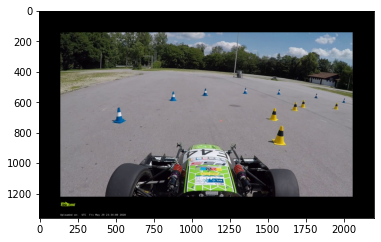

In [2]:
img = cv2.imread('fsoco_sample/images/ff_00258.png')
img_rgb = img[:,:,::-1]
plt.imshow(img_rgb)

Now let's crop everything, which is not part of the actual image:

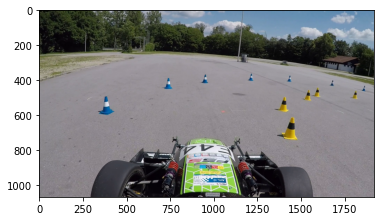

In [3]:
crop_x = 140
crop_w = 1920
crop_y = 140
crop_h = 1070
cropped = img[crop_y:crop_y+crop_h, crop_x:crop_x+crop_w]

cropped_rgb = cropped[:,:,::-1]
plt.imshow(cropped_rgb)

## Exhaustive Search/Sliding Window

*Sliding Window* is a typical approach for object detection. We will now go through all the steps to visualize how it works.

In [4]:
file_path_gt = "fsoco_sample/bounding_boxes/ff_00258.png.json"
with open(file_path_gt) as f:
    data = json.load(f)

#Extract GT-Positions
cones_gt = []
for cone in data["objects"]:
    cones_gt.append(cone["points"]["exterior"])
    
#Correct cropping coordinates
for i in range(len(cones_gt)):
    cones_gt[i][0][0] = cones_gt[i][0][0]-crop_x
    cones_gt[i][0][1] = cones_gt[i][0][1]-crop_y
    cones_gt[i][1][0] = cones_gt[i][1][0]-crop_x
    cones_gt[i][1][1] = cones_gt[i][1][1]-crop_y

Now, lets test if Ground Truth Data have been loaded correctly

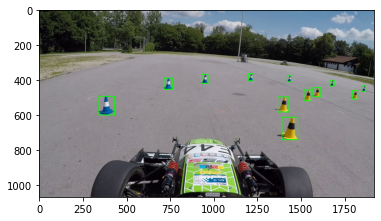

In [5]:
gt_img = cropped.copy()

for cone in cones_gt:
    cv2.rectangle(gt_img, (cone[0][0],cone[0][1]), (cone[1][0],cone[1][1]), (0,255,0), 3)
gt_img_plt = gt_img[:,:,::-1]
plt.imshow(gt_img_plt)

In [6]:
def intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0

    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [7]:
# Fake feature detector, which outputs if an image patch contains cone with IoU over 0.2
def fake_detector(x, y, width, height, iou_thresh=0.2):
    for cone in cones_gt:
        #Check if center is inside of cube
        center_x = cone[0][0]+(cone[1][0]-cone[0][0])/2
        center_y = cone[0][1]+(cone[1][1]-cone[0][1])/2
        if(center_x<x+width and center_x>x and center_y<y+height and center_y>y):
            boxA = [cone[0][0], cone[0][1], cone[1][0], cone[1][1]]
            boxB = [x, y, x+width, y+height]
            if(intersection_over_union(boxA, boxB)>iou_thresh):
                return True, intersection_over_union(boxA, boxB)
    return False, 0.0

In [8]:
bbImage = cropped.copy()

# Define Parameters
bounding_box_sizes = [50, 75, 100]
horizontal_stride = 25
vertical_stride = 25

img_height = bbImage.shape[0]
img_width = bbImage.shape[1]
# Make temporary copy of image
iteration = 0

bounding_boxes = []

out = cv2.VideoWriter('sliding_window.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 240, (img_width, img_height))

for bounding_box_size in bounding_box_sizes:
    for y in range(0, img_height, vertical_stride):
        for x in range(0, img_width, horizontal_stride):
            print("Processing Bounding Box of Size "+str(bounding_box_size)+" at x:"+str(x)+" y:"+str(y))
            # Plot current window
            tempimg = bbImage.copy()
            detected, IoU = fake_detector(x,y,bounding_box_size,bounding_box_size)
            if detected:
                cv2.rectangle(bbImage, (x,y), (x+bounding_box_size, y+bounding_box_size), (0,255,0), 6)
                cv2.rectangle(tempimg, (x,y), (x+bounding_box_size, y+bounding_box_size), (0,255,0), 6)
                bounding_boxes.append([x,y,bounding_box_size, IoU])
            else:
                cv2.rectangle(tempimg, (x,y), (x+bounding_box_size, y+bounding_box_size), (255,0,0), 6)
            iteration+=1
            out.write(tempimg)
out.release()
print("Video Recording Completed")

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Processing Bounding Box of Size 50 at x:0 y:0
Processing Bounding Box of Size 50 at x:25 y:0
Processing Bounding Box of Size 50 at x:50 y:0
Processing Bounding Box of Size 50 at x:75 y:0
Processing Bounding Box of Size 50 at x:100 y:0
Processing Bounding Box of Size 50 at x:125 y:0
Processing Bounding Box of Size 50 at x:150 y:0
Processing Bounding Box of Size 50 at x:175 y:0
Processing Bounding Box of Size 50 at x:200 y:0
Processing Bounding Box of Size 50 at x:225 y:0
Processing Bounding Box of Size 50 at x:250 y:0
Processing Bounding Box of Size 50 at x:275 y:0
Processing Bounding Box of Size 50 at x:300 y:0
Processing Bounding Box of Size 50 at x:325 y:0
Processing Bounding Box of Size 50 at x:350 y:0
Processing Bounding Box of Size 50 at x:375 y:0
Processing Bounding Box of Size 50 at x:400 y:0
Processing Bounding Box of Size 50 at x:425 y:0
Processing Bounding Box of Size 50 at x:450 y:0
Processing Bounding Box of Size 50 at x:475 y:0
Processing Bounding Box of Size 50 at x:500 y

Processing Bounding Box of Size 50 at x:675 y:50
Processing Bounding Box of Size 50 at x:700 y:50
Processing Bounding Box of Size 50 at x:725 y:50
Processing Bounding Box of Size 50 at x:750 y:50
Processing Bounding Box of Size 50 at x:775 y:50
Processing Bounding Box of Size 50 at x:800 y:50
Processing Bounding Box of Size 50 at x:825 y:50
Processing Bounding Box of Size 50 at x:850 y:50
Processing Bounding Box of Size 50 at x:875 y:50
Processing Bounding Box of Size 50 at x:900 y:50
Processing Bounding Box of Size 50 at x:925 y:50
Processing Bounding Box of Size 50 at x:950 y:50
Processing Bounding Box of Size 50 at x:975 y:50
Processing Bounding Box of Size 50 at x:1000 y:50
Processing Bounding Box of Size 50 at x:1025 y:50
Processing Bounding Box of Size 50 at x:1050 y:50
Processing Bounding Box of Size 50 at x:1075 y:50
Processing Bounding Box of Size 50 at x:1100 y:50
Processing Bounding Box of Size 50 at x:1125 y:50
Processing Bounding Box of Size 50 at x:1150 y:50
Processing Bo

Processing Bounding Box of Size 50 at x:1000 y:100
Processing Bounding Box of Size 50 at x:1025 y:100
Processing Bounding Box of Size 50 at x:1050 y:100
Processing Bounding Box of Size 50 at x:1075 y:100
Processing Bounding Box of Size 50 at x:1100 y:100
Processing Bounding Box of Size 50 at x:1125 y:100
Processing Bounding Box of Size 50 at x:1150 y:100
Processing Bounding Box of Size 50 at x:1175 y:100
Processing Bounding Box of Size 50 at x:1200 y:100
Processing Bounding Box of Size 50 at x:1225 y:100
Processing Bounding Box of Size 50 at x:1250 y:100
Processing Bounding Box of Size 50 at x:1275 y:100
Processing Bounding Box of Size 50 at x:1300 y:100
Processing Bounding Box of Size 50 at x:1325 y:100
Processing Bounding Box of Size 50 at x:1350 y:100
Processing Bounding Box of Size 50 at x:1375 y:100
Processing Bounding Box of Size 50 at x:1400 y:100
Processing Bounding Box of Size 50 at x:1425 y:100
Processing Bounding Box of Size 50 at x:1450 y:100
Processing Bounding Box of Size

Processing Bounding Box of Size 50 at x:1500 y:150
Processing Bounding Box of Size 50 at x:1525 y:150
Processing Bounding Box of Size 50 at x:1550 y:150
Processing Bounding Box of Size 50 at x:1575 y:150
Processing Bounding Box of Size 50 at x:1600 y:150
Processing Bounding Box of Size 50 at x:1625 y:150
Processing Bounding Box of Size 50 at x:1650 y:150
Processing Bounding Box of Size 50 at x:1675 y:150
Processing Bounding Box of Size 50 at x:1700 y:150
Processing Bounding Box of Size 50 at x:1725 y:150
Processing Bounding Box of Size 50 at x:1750 y:150
Processing Bounding Box of Size 50 at x:1775 y:150
Processing Bounding Box of Size 50 at x:1800 y:150
Processing Bounding Box of Size 50 at x:1825 y:150
Processing Bounding Box of Size 50 at x:1850 y:150
Processing Bounding Box of Size 50 at x:1875 y:150
Processing Bounding Box of Size 50 at x:1900 y:150
Processing Bounding Box of Size 50 at x:0 y:175
Processing Bounding Box of Size 50 at x:25 y:175
Processing Bounding Box of Size 50 a

Processing Bounding Box of Size 50 at x:125 y:225
Processing Bounding Box of Size 50 at x:150 y:225
Processing Bounding Box of Size 50 at x:175 y:225
Processing Bounding Box of Size 50 at x:200 y:225
Processing Bounding Box of Size 50 at x:225 y:225
Processing Bounding Box of Size 50 at x:250 y:225
Processing Bounding Box of Size 50 at x:275 y:225
Processing Bounding Box of Size 50 at x:300 y:225
Processing Bounding Box of Size 50 at x:325 y:225
Processing Bounding Box of Size 50 at x:350 y:225
Processing Bounding Box of Size 50 at x:375 y:225
Processing Bounding Box of Size 50 at x:400 y:225
Processing Bounding Box of Size 50 at x:425 y:225
Processing Bounding Box of Size 50 at x:450 y:225
Processing Bounding Box of Size 50 at x:475 y:225
Processing Bounding Box of Size 50 at x:500 y:225
Processing Bounding Box of Size 50 at x:525 y:225
Processing Bounding Box of Size 50 at x:550 y:225
Processing Bounding Box of Size 50 at x:575 y:225
Processing Bounding Box of Size 50 at x:600 y:225


Processing Bounding Box of Size 50 at x:825 y:275
Processing Bounding Box of Size 50 at x:850 y:275
Processing Bounding Box of Size 50 at x:875 y:275
Processing Bounding Box of Size 50 at x:900 y:275
Processing Bounding Box of Size 50 at x:925 y:275
Processing Bounding Box of Size 50 at x:950 y:275
Processing Bounding Box of Size 50 at x:975 y:275
Processing Bounding Box of Size 50 at x:1000 y:275
Processing Bounding Box of Size 50 at x:1025 y:275
Processing Bounding Box of Size 50 at x:1050 y:275
Processing Bounding Box of Size 50 at x:1075 y:275
Processing Bounding Box of Size 50 at x:1100 y:275
Processing Bounding Box of Size 50 at x:1125 y:275
Processing Bounding Box of Size 50 at x:1150 y:275
Processing Bounding Box of Size 50 at x:1175 y:275
Processing Bounding Box of Size 50 at x:1200 y:275
Processing Bounding Box of Size 50 at x:1225 y:275
Processing Bounding Box of Size 50 at x:1250 y:275
Processing Bounding Box of Size 50 at x:1275 y:275
Processing Bounding Box of Size 50 at 

Processing Bounding Box of Size 50 at x:1575 y:325
Processing Bounding Box of Size 50 at x:1600 y:325
Processing Bounding Box of Size 50 at x:1625 y:325
Processing Bounding Box of Size 50 at x:1650 y:325
Processing Bounding Box of Size 50 at x:1675 y:325
Processing Bounding Box of Size 50 at x:1700 y:325
Processing Bounding Box of Size 50 at x:1725 y:325
Processing Bounding Box of Size 50 at x:1750 y:325
Processing Bounding Box of Size 50 at x:1775 y:325
Processing Bounding Box of Size 50 at x:1800 y:325
Processing Bounding Box of Size 50 at x:1825 y:325
Processing Bounding Box of Size 50 at x:1850 y:325
Processing Bounding Box of Size 50 at x:1875 y:325
Processing Bounding Box of Size 50 at x:1900 y:325
Processing Bounding Box of Size 50 at x:0 y:350
Processing Bounding Box of Size 50 at x:25 y:350
Processing Bounding Box of Size 50 at x:50 y:350
Processing Bounding Box of Size 50 at x:75 y:350
Processing Bounding Box of Size 50 at x:100 y:350
Processing Bounding Box of Size 50 at x:1

Processing Bounding Box of Size 50 at x:300 y:400
Processing Bounding Box of Size 50 at x:325 y:400
Processing Bounding Box of Size 50 at x:350 y:400
Processing Bounding Box of Size 50 at x:375 y:400
Processing Bounding Box of Size 50 at x:400 y:400
Processing Bounding Box of Size 50 at x:425 y:400
Processing Bounding Box of Size 50 at x:450 y:400
Processing Bounding Box of Size 50 at x:475 y:400
Processing Bounding Box of Size 50 at x:500 y:400
Processing Bounding Box of Size 50 at x:525 y:400
Processing Bounding Box of Size 50 at x:550 y:400
Processing Bounding Box of Size 50 at x:575 y:400
Processing Bounding Box of Size 50 at x:600 y:400
Processing Bounding Box of Size 50 at x:625 y:400
Processing Bounding Box of Size 50 at x:650 y:400
Processing Bounding Box of Size 50 at x:675 y:400
Processing Bounding Box of Size 50 at x:700 y:400
Processing Bounding Box of Size 50 at x:725 y:400
Processing Bounding Box of Size 50 at x:750 y:400
Processing Bounding Box of Size 50 at x:775 y:400


Processing Bounding Box of Size 50 at x:925 y:450
Processing Bounding Box of Size 50 at x:950 y:450
Processing Bounding Box of Size 50 at x:975 y:450
Processing Bounding Box of Size 50 at x:1000 y:450
Processing Bounding Box of Size 50 at x:1025 y:450
Processing Bounding Box of Size 50 at x:1050 y:450
Processing Bounding Box of Size 50 at x:1075 y:450
Processing Bounding Box of Size 50 at x:1100 y:450
Processing Bounding Box of Size 50 at x:1125 y:450
Processing Bounding Box of Size 50 at x:1150 y:450
Processing Bounding Box of Size 50 at x:1175 y:450
Processing Bounding Box of Size 50 at x:1200 y:450
Processing Bounding Box of Size 50 at x:1225 y:450
Processing Bounding Box of Size 50 at x:1250 y:450
Processing Bounding Box of Size 50 at x:1275 y:450
Processing Bounding Box of Size 50 at x:1300 y:450
Processing Bounding Box of Size 50 at x:1325 y:450
Processing Bounding Box of Size 50 at x:1350 y:450
Processing Bounding Box of Size 50 at x:1375 y:450
Processing Bounding Box of Size 50

Processing Bounding Box of Size 50 at x:1500 y:500
Processing Bounding Box of Size 50 at x:1525 y:500
Processing Bounding Box of Size 50 at x:1550 y:500
Processing Bounding Box of Size 50 at x:1575 y:500
Processing Bounding Box of Size 50 at x:1600 y:500
Processing Bounding Box of Size 50 at x:1625 y:500
Processing Bounding Box of Size 50 at x:1650 y:500
Processing Bounding Box of Size 50 at x:1675 y:500
Processing Bounding Box of Size 50 at x:1700 y:500
Processing Bounding Box of Size 50 at x:1725 y:500
Processing Bounding Box of Size 50 at x:1750 y:500
Processing Bounding Box of Size 50 at x:1775 y:500
Processing Bounding Box of Size 50 at x:1800 y:500
Processing Bounding Box of Size 50 at x:1825 y:500
Processing Bounding Box of Size 50 at x:1850 y:500
Processing Bounding Box of Size 50 at x:1875 y:500
Processing Bounding Box of Size 50 at x:1900 y:500
Processing Bounding Box of Size 50 at x:0 y:525
Processing Bounding Box of Size 50 at x:25 y:525
Processing Bounding Box of Size 50 a

Processing Bounding Box of Size 50 at x:1900 y:550
Processing Bounding Box of Size 50 at x:0 y:575
Processing Bounding Box of Size 50 at x:25 y:575
Processing Bounding Box of Size 50 at x:50 y:575
Processing Bounding Box of Size 50 at x:75 y:575
Processing Bounding Box of Size 50 at x:100 y:575
Processing Bounding Box of Size 50 at x:125 y:575
Processing Bounding Box of Size 50 at x:150 y:575
Processing Bounding Box of Size 50 at x:175 y:575
Processing Bounding Box of Size 50 at x:200 y:575
Processing Bounding Box of Size 50 at x:225 y:575
Processing Bounding Box of Size 50 at x:250 y:575
Processing Bounding Box of Size 50 at x:275 y:575
Processing Bounding Box of Size 50 at x:300 y:575
Processing Bounding Box of Size 50 at x:325 y:575
Processing Bounding Box of Size 50 at x:350 y:575
Processing Bounding Box of Size 50 at x:375 y:575
Processing Bounding Box of Size 50 at x:400 y:575
Processing Bounding Box of Size 50 at x:425 y:575
Processing Bounding Box of Size 50 at x:450 y:575
Proc

Processing Bounding Box of Size 50 at x:425 y:625
Processing Bounding Box of Size 50 at x:450 y:625
Processing Bounding Box of Size 50 at x:475 y:625
Processing Bounding Box of Size 50 at x:500 y:625
Processing Bounding Box of Size 50 at x:525 y:625
Processing Bounding Box of Size 50 at x:550 y:625
Processing Bounding Box of Size 50 at x:575 y:625
Processing Bounding Box of Size 50 at x:600 y:625
Processing Bounding Box of Size 50 at x:625 y:625
Processing Bounding Box of Size 50 at x:650 y:625
Processing Bounding Box of Size 50 at x:675 y:625
Processing Bounding Box of Size 50 at x:700 y:625
Processing Bounding Box of Size 50 at x:725 y:625
Processing Bounding Box of Size 50 at x:750 y:625
Processing Bounding Box of Size 50 at x:775 y:625
Processing Bounding Box of Size 50 at x:800 y:625
Processing Bounding Box of Size 50 at x:825 y:625
Processing Bounding Box of Size 50 at x:850 y:625
Processing Bounding Box of Size 50 at x:875 y:625
Processing Bounding Box of Size 50 at x:900 y:625


Processing Bounding Box of Size 50 at x:1075 y:675
Processing Bounding Box of Size 50 at x:1100 y:675
Processing Bounding Box of Size 50 at x:1125 y:675
Processing Bounding Box of Size 50 at x:1150 y:675
Processing Bounding Box of Size 50 at x:1175 y:675
Processing Bounding Box of Size 50 at x:1200 y:675
Processing Bounding Box of Size 50 at x:1225 y:675
Processing Bounding Box of Size 50 at x:1250 y:675
Processing Bounding Box of Size 50 at x:1275 y:675
Processing Bounding Box of Size 50 at x:1300 y:675
Processing Bounding Box of Size 50 at x:1325 y:675
Processing Bounding Box of Size 50 at x:1350 y:675
Processing Bounding Box of Size 50 at x:1375 y:675
Processing Bounding Box of Size 50 at x:1400 y:675
Processing Bounding Box of Size 50 at x:1425 y:675
Processing Bounding Box of Size 50 at x:1450 y:675
Processing Bounding Box of Size 50 at x:1475 y:675
Processing Bounding Box of Size 50 at x:1500 y:675
Processing Bounding Box of Size 50 at x:1525 y:675
Processing Bounding Box of Size

Processing Bounding Box of Size 50 at x:1775 y:725
Processing Bounding Box of Size 50 at x:1800 y:725
Processing Bounding Box of Size 50 at x:1825 y:725
Processing Bounding Box of Size 50 at x:1850 y:725
Processing Bounding Box of Size 50 at x:1875 y:725
Processing Bounding Box of Size 50 at x:1900 y:725
Processing Bounding Box of Size 50 at x:0 y:750
Processing Bounding Box of Size 50 at x:25 y:750
Processing Bounding Box of Size 50 at x:50 y:750
Processing Bounding Box of Size 50 at x:75 y:750
Processing Bounding Box of Size 50 at x:100 y:750
Processing Bounding Box of Size 50 at x:125 y:750
Processing Bounding Box of Size 50 at x:150 y:750
Processing Bounding Box of Size 50 at x:175 y:750
Processing Bounding Box of Size 50 at x:200 y:750
Processing Bounding Box of Size 50 at x:225 y:750
Processing Bounding Box of Size 50 at x:250 y:750
Processing Bounding Box of Size 50 at x:275 y:750
Processing Bounding Box of Size 50 at x:300 y:750
Processing Bounding Box of Size 50 at x:325 y:750

Processing Bounding Box of Size 50 at x:475 y:800
Processing Bounding Box of Size 50 at x:500 y:800
Processing Bounding Box of Size 50 at x:525 y:800
Processing Bounding Box of Size 50 at x:550 y:800
Processing Bounding Box of Size 50 at x:575 y:800
Processing Bounding Box of Size 50 at x:600 y:800
Processing Bounding Box of Size 50 at x:625 y:800
Processing Bounding Box of Size 50 at x:650 y:800
Processing Bounding Box of Size 50 at x:675 y:800
Processing Bounding Box of Size 50 at x:700 y:800
Processing Bounding Box of Size 50 at x:725 y:800
Processing Bounding Box of Size 50 at x:750 y:800
Processing Bounding Box of Size 50 at x:775 y:800
Processing Bounding Box of Size 50 at x:800 y:800
Processing Bounding Box of Size 50 at x:825 y:800
Processing Bounding Box of Size 50 at x:850 y:800
Processing Bounding Box of Size 50 at x:875 y:800
Processing Bounding Box of Size 50 at x:900 y:800
Processing Bounding Box of Size 50 at x:925 y:800
Processing Bounding Box of Size 50 at x:950 y:800


Processing Bounding Box of Size 50 at x:1175 y:850
Processing Bounding Box of Size 50 at x:1200 y:850
Processing Bounding Box of Size 50 at x:1225 y:850
Processing Bounding Box of Size 50 at x:1250 y:850
Processing Bounding Box of Size 50 at x:1275 y:850
Processing Bounding Box of Size 50 at x:1300 y:850
Processing Bounding Box of Size 50 at x:1325 y:850
Processing Bounding Box of Size 50 at x:1350 y:850
Processing Bounding Box of Size 50 at x:1375 y:850
Processing Bounding Box of Size 50 at x:1400 y:850
Processing Bounding Box of Size 50 at x:1425 y:850
Processing Bounding Box of Size 50 at x:1450 y:850
Processing Bounding Box of Size 50 at x:1475 y:850
Processing Bounding Box of Size 50 at x:1500 y:850
Processing Bounding Box of Size 50 at x:1525 y:850
Processing Bounding Box of Size 50 at x:1550 y:850
Processing Bounding Box of Size 50 at x:1575 y:850
Processing Bounding Box of Size 50 at x:1600 y:850
Processing Bounding Box of Size 50 at x:1625 y:850
Processing Bounding Box of Size

Processing Bounding Box of Size 50 at x:1850 y:900
Processing Bounding Box of Size 50 at x:1875 y:900
Processing Bounding Box of Size 50 at x:1900 y:900
Processing Bounding Box of Size 50 at x:0 y:925
Processing Bounding Box of Size 50 at x:25 y:925
Processing Bounding Box of Size 50 at x:50 y:925
Processing Bounding Box of Size 50 at x:75 y:925
Processing Bounding Box of Size 50 at x:100 y:925
Processing Bounding Box of Size 50 at x:125 y:925
Processing Bounding Box of Size 50 at x:150 y:925
Processing Bounding Box of Size 50 at x:175 y:925
Processing Bounding Box of Size 50 at x:200 y:925
Processing Bounding Box of Size 50 at x:225 y:925
Processing Bounding Box of Size 50 at x:250 y:925
Processing Bounding Box of Size 50 at x:275 y:925
Processing Bounding Box of Size 50 at x:300 y:925
Processing Bounding Box of Size 50 at x:325 y:925
Processing Bounding Box of Size 50 at x:350 y:925
Processing Bounding Box of Size 50 at x:375 y:925
Processing Bounding Box of Size 50 at x:400 y:925
Pr

Processing Bounding Box of Size 50 at x:575 y:975
Processing Bounding Box of Size 50 at x:600 y:975
Processing Bounding Box of Size 50 at x:625 y:975
Processing Bounding Box of Size 50 at x:650 y:975
Processing Bounding Box of Size 50 at x:675 y:975
Processing Bounding Box of Size 50 at x:700 y:975
Processing Bounding Box of Size 50 at x:725 y:975
Processing Bounding Box of Size 50 at x:750 y:975
Processing Bounding Box of Size 50 at x:775 y:975
Processing Bounding Box of Size 50 at x:800 y:975
Processing Bounding Box of Size 50 at x:825 y:975
Processing Bounding Box of Size 50 at x:850 y:975
Processing Bounding Box of Size 50 at x:875 y:975
Processing Bounding Box of Size 50 at x:900 y:975
Processing Bounding Box of Size 50 at x:925 y:975
Processing Bounding Box of Size 50 at x:950 y:975
Processing Bounding Box of Size 50 at x:975 y:975
Processing Bounding Box of Size 50 at x:1000 y:975
Processing Bounding Box of Size 50 at x:1025 y:975
Processing Bounding Box of Size 50 at x:1050 y:9

Processing Bounding Box of Size 50 at x:1250 y:1025
Processing Bounding Box of Size 50 at x:1275 y:1025
Processing Bounding Box of Size 50 at x:1300 y:1025
Processing Bounding Box of Size 50 at x:1325 y:1025
Processing Bounding Box of Size 50 at x:1350 y:1025
Processing Bounding Box of Size 50 at x:1375 y:1025
Processing Bounding Box of Size 50 at x:1400 y:1025
Processing Bounding Box of Size 50 at x:1425 y:1025
Processing Bounding Box of Size 50 at x:1450 y:1025
Processing Bounding Box of Size 50 at x:1475 y:1025
Processing Bounding Box of Size 50 at x:1500 y:1025
Processing Bounding Box of Size 50 at x:1525 y:1025
Processing Bounding Box of Size 50 at x:1550 y:1025
Processing Bounding Box of Size 50 at x:1575 y:1025
Processing Bounding Box of Size 50 at x:1600 y:1025
Processing Bounding Box of Size 50 at x:1625 y:1025
Processing Bounding Box of Size 50 at x:1650 y:1025
Processing Bounding Box of Size 50 at x:1675 y:1025
Processing Bounding Box of Size 50 at x:1700 y:1025
Processing B

Processing Bounding Box of Size 75 at x:1900 y:0
Processing Bounding Box of Size 75 at x:0 y:25
Processing Bounding Box of Size 75 at x:25 y:25
Processing Bounding Box of Size 75 at x:50 y:25
Processing Bounding Box of Size 75 at x:75 y:25
Processing Bounding Box of Size 75 at x:100 y:25
Processing Bounding Box of Size 75 at x:125 y:25
Processing Bounding Box of Size 75 at x:150 y:25
Processing Bounding Box of Size 75 at x:175 y:25
Processing Bounding Box of Size 75 at x:200 y:25
Processing Bounding Box of Size 75 at x:225 y:25
Processing Bounding Box of Size 75 at x:250 y:25
Processing Bounding Box of Size 75 at x:275 y:25
Processing Bounding Box of Size 75 at x:300 y:25
Processing Bounding Box of Size 75 at x:325 y:25
Processing Bounding Box of Size 75 at x:350 y:25
Processing Bounding Box of Size 75 at x:375 y:25
Processing Bounding Box of Size 75 at x:400 y:25
Processing Bounding Box of Size 75 at x:425 y:25
Processing Bounding Box of Size 75 at x:450 y:25
Processing Bounding Box o

Processing Bounding Box of Size 75 at x:625 y:75
Processing Bounding Box of Size 75 at x:650 y:75
Processing Bounding Box of Size 75 at x:675 y:75
Processing Bounding Box of Size 75 at x:700 y:75
Processing Bounding Box of Size 75 at x:725 y:75
Processing Bounding Box of Size 75 at x:750 y:75
Processing Bounding Box of Size 75 at x:775 y:75
Processing Bounding Box of Size 75 at x:800 y:75
Processing Bounding Box of Size 75 at x:825 y:75
Processing Bounding Box of Size 75 at x:850 y:75
Processing Bounding Box of Size 75 at x:875 y:75
Processing Bounding Box of Size 75 at x:900 y:75
Processing Bounding Box of Size 75 at x:925 y:75
Processing Bounding Box of Size 75 at x:950 y:75
Processing Bounding Box of Size 75 at x:975 y:75
Processing Bounding Box of Size 75 at x:1000 y:75
Processing Bounding Box of Size 75 at x:1025 y:75
Processing Bounding Box of Size 75 at x:1050 y:75
Processing Bounding Box of Size 75 at x:1075 y:75
Processing Bounding Box of Size 75 at x:1100 y:75
Processing Boun

Processing Bounding Box of Size 75 at x:1225 y:125
Processing Bounding Box of Size 75 at x:1250 y:125
Processing Bounding Box of Size 75 at x:1275 y:125
Processing Bounding Box of Size 75 at x:1300 y:125
Processing Bounding Box of Size 75 at x:1325 y:125
Processing Bounding Box of Size 75 at x:1350 y:125
Processing Bounding Box of Size 75 at x:1375 y:125
Processing Bounding Box of Size 75 at x:1400 y:125
Processing Bounding Box of Size 75 at x:1425 y:125
Processing Bounding Box of Size 75 at x:1450 y:125
Processing Bounding Box of Size 75 at x:1475 y:125
Processing Bounding Box of Size 75 at x:1500 y:125
Processing Bounding Box of Size 75 at x:1525 y:125
Processing Bounding Box of Size 75 at x:1550 y:125
Processing Bounding Box of Size 75 at x:1575 y:125
Processing Bounding Box of Size 75 at x:1600 y:125
Processing Bounding Box of Size 75 at x:1625 y:125
Processing Bounding Box of Size 75 at x:1650 y:125
Processing Bounding Box of Size 75 at x:1675 y:125
Processing Bounding Box of Size

Processing Bounding Box of Size 75 at x:1700 y:175
Processing Bounding Box of Size 75 at x:1725 y:175
Processing Bounding Box of Size 75 at x:1750 y:175
Processing Bounding Box of Size 75 at x:1775 y:175
Processing Bounding Box of Size 75 at x:1800 y:175
Processing Bounding Box of Size 75 at x:1825 y:175
Processing Bounding Box of Size 75 at x:1850 y:175
Processing Bounding Box of Size 75 at x:1875 y:175
Processing Bounding Box of Size 75 at x:1900 y:175
Processing Bounding Box of Size 75 at x:0 y:200
Processing Bounding Box of Size 75 at x:25 y:200
Processing Bounding Box of Size 75 at x:50 y:200
Processing Bounding Box of Size 75 at x:75 y:200
Processing Bounding Box of Size 75 at x:100 y:200
Processing Bounding Box of Size 75 at x:125 y:200
Processing Bounding Box of Size 75 at x:150 y:200
Processing Bounding Box of Size 75 at x:175 y:200
Processing Bounding Box of Size 75 at x:200 y:200
Processing Bounding Box of Size 75 at x:225 y:200
Processing Bounding Box of Size 75 at x:250 y:

Processing Bounding Box of Size 75 at x:400 y:250
Processing Bounding Box of Size 75 at x:425 y:250
Processing Bounding Box of Size 75 at x:450 y:250
Processing Bounding Box of Size 75 at x:475 y:250
Processing Bounding Box of Size 75 at x:500 y:250
Processing Bounding Box of Size 75 at x:525 y:250
Processing Bounding Box of Size 75 at x:550 y:250
Processing Bounding Box of Size 75 at x:575 y:250
Processing Bounding Box of Size 75 at x:600 y:250
Processing Bounding Box of Size 75 at x:625 y:250
Processing Bounding Box of Size 75 at x:650 y:250
Processing Bounding Box of Size 75 at x:675 y:250
Processing Bounding Box of Size 75 at x:700 y:250
Processing Bounding Box of Size 75 at x:725 y:250
Processing Bounding Box of Size 75 at x:750 y:250
Processing Bounding Box of Size 75 at x:775 y:250
Processing Bounding Box of Size 75 at x:800 y:250
Processing Bounding Box of Size 75 at x:825 y:250
Processing Bounding Box of Size 75 at x:850 y:250
Processing Bounding Box of Size 75 at x:875 y:250


Processing Bounding Box of Size 75 at x:650 y:300
Processing Bounding Box of Size 75 at x:675 y:300
Processing Bounding Box of Size 75 at x:700 y:300
Processing Bounding Box of Size 75 at x:725 y:300
Processing Bounding Box of Size 75 at x:750 y:300
Processing Bounding Box of Size 75 at x:775 y:300
Processing Bounding Box of Size 75 at x:800 y:300
Processing Bounding Box of Size 75 at x:825 y:300
Processing Bounding Box of Size 75 at x:850 y:300
Processing Bounding Box of Size 75 at x:875 y:300
Processing Bounding Box of Size 75 at x:900 y:300
Processing Bounding Box of Size 75 at x:925 y:300
Processing Bounding Box of Size 75 at x:950 y:300
Processing Bounding Box of Size 75 at x:975 y:300
Processing Bounding Box of Size 75 at x:1000 y:300
Processing Bounding Box of Size 75 at x:1025 y:300
Processing Bounding Box of Size 75 at x:1050 y:300
Processing Bounding Box of Size 75 at x:1075 y:300
Processing Bounding Box of Size 75 at x:1100 y:300
Processing Bounding Box of Size 75 at x:1125 

Processing Bounding Box of Size 75 at x:1400 y:350
Processing Bounding Box of Size 75 at x:1425 y:350
Processing Bounding Box of Size 75 at x:1450 y:350
Processing Bounding Box of Size 75 at x:1475 y:350
Processing Bounding Box of Size 75 at x:1500 y:350
Processing Bounding Box of Size 75 at x:1525 y:350
Processing Bounding Box of Size 75 at x:1550 y:350
Processing Bounding Box of Size 75 at x:1575 y:350
Processing Bounding Box of Size 75 at x:1600 y:350
Processing Bounding Box of Size 75 at x:1625 y:350
Processing Bounding Box of Size 75 at x:1650 y:350
Processing Bounding Box of Size 75 at x:1675 y:350
Processing Bounding Box of Size 75 at x:1700 y:350
Processing Bounding Box of Size 75 at x:1725 y:350
Processing Bounding Box of Size 75 at x:1750 y:350
Processing Bounding Box of Size 75 at x:1775 y:350
Processing Bounding Box of Size 75 at x:1800 y:350
Processing Bounding Box of Size 75 at x:1825 y:350
Processing Bounding Box of Size 75 at x:1850 y:350
Processing Bounding Box of Size

Processing Bounding Box of Size 75 at x:25 y:425
Processing Bounding Box of Size 75 at x:50 y:425
Processing Bounding Box of Size 75 at x:75 y:425
Processing Bounding Box of Size 75 at x:100 y:425
Processing Bounding Box of Size 75 at x:125 y:425
Processing Bounding Box of Size 75 at x:150 y:425
Processing Bounding Box of Size 75 at x:175 y:425
Processing Bounding Box of Size 75 at x:200 y:425
Processing Bounding Box of Size 75 at x:225 y:425
Processing Bounding Box of Size 75 at x:250 y:425
Processing Bounding Box of Size 75 at x:275 y:425
Processing Bounding Box of Size 75 at x:300 y:425
Processing Bounding Box of Size 75 at x:325 y:425
Processing Bounding Box of Size 75 at x:350 y:425
Processing Bounding Box of Size 75 at x:375 y:425
Processing Bounding Box of Size 75 at x:400 y:425
Processing Bounding Box of Size 75 at x:425 y:425
Processing Bounding Box of Size 75 at x:450 y:425
Processing Bounding Box of Size 75 at x:475 y:425
Processing Bounding Box of Size 75 at x:500 y:425
Pro

Processing Bounding Box of Size 75 at x:600 y:475
Processing Bounding Box of Size 75 at x:625 y:475
Processing Bounding Box of Size 75 at x:650 y:475
Processing Bounding Box of Size 75 at x:675 y:475
Processing Bounding Box of Size 75 at x:700 y:475
Processing Bounding Box of Size 75 at x:725 y:475
Processing Bounding Box of Size 75 at x:750 y:475
Processing Bounding Box of Size 75 at x:775 y:475
Processing Bounding Box of Size 75 at x:800 y:475
Processing Bounding Box of Size 75 at x:825 y:475
Processing Bounding Box of Size 75 at x:850 y:475
Processing Bounding Box of Size 75 at x:875 y:475
Processing Bounding Box of Size 75 at x:900 y:475
Processing Bounding Box of Size 75 at x:925 y:475
Processing Bounding Box of Size 75 at x:950 y:475
Processing Bounding Box of Size 75 at x:975 y:475
Processing Bounding Box of Size 75 at x:1000 y:475
Processing Bounding Box of Size 75 at x:1025 y:475
Processing Bounding Box of Size 75 at x:1050 y:475
Processing Bounding Box of Size 75 at x:1075 y:

Processing Bounding Box of Size 75 at x:1050 y:525
Processing Bounding Box of Size 75 at x:1075 y:525
Processing Bounding Box of Size 75 at x:1100 y:525
Processing Bounding Box of Size 75 at x:1125 y:525
Processing Bounding Box of Size 75 at x:1150 y:525
Processing Bounding Box of Size 75 at x:1175 y:525
Processing Bounding Box of Size 75 at x:1200 y:525
Processing Bounding Box of Size 75 at x:1225 y:525
Processing Bounding Box of Size 75 at x:1250 y:525
Processing Bounding Box of Size 75 at x:1275 y:525
Processing Bounding Box of Size 75 at x:1300 y:525
Processing Bounding Box of Size 75 at x:1325 y:525
Processing Bounding Box of Size 75 at x:1350 y:525
Processing Bounding Box of Size 75 at x:1375 y:525
Processing Bounding Box of Size 75 at x:1400 y:525
Processing Bounding Box of Size 75 at x:1425 y:525
Processing Bounding Box of Size 75 at x:1450 y:525
Processing Bounding Box of Size 75 at x:1475 y:525
Processing Bounding Box of Size 75 at x:1500 y:525
Processing Bounding Box of Size

Processing Bounding Box of Size 75 at x:1650 y:575
Processing Bounding Box of Size 75 at x:1675 y:575
Processing Bounding Box of Size 75 at x:1700 y:575
Processing Bounding Box of Size 75 at x:1725 y:575
Processing Bounding Box of Size 75 at x:1750 y:575
Processing Bounding Box of Size 75 at x:1775 y:575
Processing Bounding Box of Size 75 at x:1800 y:575
Processing Bounding Box of Size 75 at x:1825 y:575
Processing Bounding Box of Size 75 at x:1850 y:575
Processing Bounding Box of Size 75 at x:1875 y:575
Processing Bounding Box of Size 75 at x:1900 y:575
Processing Bounding Box of Size 75 at x:0 y:600
Processing Bounding Box of Size 75 at x:25 y:600
Processing Bounding Box of Size 75 at x:50 y:600
Processing Bounding Box of Size 75 at x:75 y:600
Processing Bounding Box of Size 75 at x:100 y:600
Processing Bounding Box of Size 75 at x:125 y:600
Processing Bounding Box of Size 75 at x:150 y:600
Processing Bounding Box of Size 75 at x:175 y:600
Processing Bounding Box of Size 75 at x:200 

Processing Bounding Box of Size 75 at x:300 y:650
Processing Bounding Box of Size 75 at x:325 y:650
Processing Bounding Box of Size 75 at x:350 y:650
Processing Bounding Box of Size 75 at x:375 y:650
Processing Bounding Box of Size 75 at x:400 y:650
Processing Bounding Box of Size 75 at x:425 y:650
Processing Bounding Box of Size 75 at x:450 y:650
Processing Bounding Box of Size 75 at x:475 y:650
Processing Bounding Box of Size 75 at x:500 y:650
Processing Bounding Box of Size 75 at x:525 y:650
Processing Bounding Box of Size 75 at x:550 y:650
Processing Bounding Box of Size 75 at x:575 y:650
Processing Bounding Box of Size 75 at x:600 y:650
Processing Bounding Box of Size 75 at x:625 y:650
Processing Bounding Box of Size 75 at x:650 y:650
Processing Bounding Box of Size 75 at x:675 y:650
Processing Bounding Box of Size 75 at x:700 y:650
Processing Bounding Box of Size 75 at x:725 y:650
Processing Bounding Box of Size 75 at x:750 y:650
Processing Bounding Box of Size 75 at x:775 y:650


Processing Bounding Box of Size 75 at x:675 y:700
Processing Bounding Box of Size 75 at x:700 y:700
Processing Bounding Box of Size 75 at x:725 y:700
Processing Bounding Box of Size 75 at x:750 y:700
Processing Bounding Box of Size 75 at x:775 y:700
Processing Bounding Box of Size 75 at x:800 y:700
Processing Bounding Box of Size 75 at x:825 y:700
Processing Bounding Box of Size 75 at x:850 y:700
Processing Bounding Box of Size 75 at x:875 y:700
Processing Bounding Box of Size 75 at x:900 y:700
Processing Bounding Box of Size 75 at x:925 y:700
Processing Bounding Box of Size 75 at x:950 y:700
Processing Bounding Box of Size 75 at x:975 y:700
Processing Bounding Box of Size 75 at x:1000 y:700
Processing Bounding Box of Size 75 at x:1025 y:700
Processing Bounding Box of Size 75 at x:1050 y:700
Processing Bounding Box of Size 75 at x:1075 y:700
Processing Bounding Box of Size 75 at x:1100 y:700
Processing Bounding Box of Size 75 at x:1125 y:700
Processing Bounding Box of Size 75 at x:1150

Processing Bounding Box of Size 75 at x:1150 y:750
Processing Bounding Box of Size 75 at x:1175 y:750
Processing Bounding Box of Size 75 at x:1200 y:750
Processing Bounding Box of Size 75 at x:1225 y:750
Processing Bounding Box of Size 75 at x:1250 y:750
Processing Bounding Box of Size 75 at x:1275 y:750
Processing Bounding Box of Size 75 at x:1300 y:750
Processing Bounding Box of Size 75 at x:1325 y:750
Processing Bounding Box of Size 75 at x:1350 y:750
Processing Bounding Box of Size 75 at x:1375 y:750
Processing Bounding Box of Size 75 at x:1400 y:750
Processing Bounding Box of Size 75 at x:1425 y:750
Processing Bounding Box of Size 75 at x:1450 y:750
Processing Bounding Box of Size 75 at x:1475 y:750
Processing Bounding Box of Size 75 at x:1500 y:750
Processing Bounding Box of Size 75 at x:1525 y:750
Processing Bounding Box of Size 75 at x:1550 y:750
Processing Bounding Box of Size 75 at x:1575 y:750
Processing Bounding Box of Size 75 at x:1600 y:750
Processing Bounding Box of Size

Processing Bounding Box of Size 75 at x:1725 y:800
Processing Bounding Box of Size 75 at x:1750 y:800
Processing Bounding Box of Size 75 at x:1775 y:800
Processing Bounding Box of Size 75 at x:1800 y:800
Processing Bounding Box of Size 75 at x:1825 y:800
Processing Bounding Box of Size 75 at x:1850 y:800
Processing Bounding Box of Size 75 at x:1875 y:800
Processing Bounding Box of Size 75 at x:1900 y:800
Processing Bounding Box of Size 75 at x:0 y:825
Processing Bounding Box of Size 75 at x:25 y:825
Processing Bounding Box of Size 75 at x:50 y:825
Processing Bounding Box of Size 75 at x:75 y:825
Processing Bounding Box of Size 75 at x:100 y:825
Processing Bounding Box of Size 75 at x:125 y:825
Processing Bounding Box of Size 75 at x:150 y:825
Processing Bounding Box of Size 75 at x:175 y:825
Processing Bounding Box of Size 75 at x:200 y:825
Processing Bounding Box of Size 75 at x:225 y:825
Processing Bounding Box of Size 75 at x:250 y:825
Processing Bounding Box of Size 75 at x:275 y:8

Processing Bounding Box of Size 75 at x:400 y:875
Processing Bounding Box of Size 75 at x:425 y:875
Processing Bounding Box of Size 75 at x:450 y:875
Processing Bounding Box of Size 75 at x:475 y:875
Processing Bounding Box of Size 75 at x:500 y:875
Processing Bounding Box of Size 75 at x:525 y:875
Processing Bounding Box of Size 75 at x:550 y:875
Processing Bounding Box of Size 75 at x:575 y:875
Processing Bounding Box of Size 75 at x:600 y:875
Processing Bounding Box of Size 75 at x:625 y:875
Processing Bounding Box of Size 75 at x:650 y:875
Processing Bounding Box of Size 75 at x:675 y:875
Processing Bounding Box of Size 75 at x:700 y:875
Processing Bounding Box of Size 75 at x:725 y:875
Processing Bounding Box of Size 75 at x:750 y:875
Processing Bounding Box of Size 75 at x:775 y:875
Processing Bounding Box of Size 75 at x:800 y:875
Processing Bounding Box of Size 75 at x:825 y:875
Processing Bounding Box of Size 75 at x:850 y:875
Processing Bounding Box of Size 75 at x:875 y:875


Processing Bounding Box of Size 75 at x:1000 y:925
Processing Bounding Box of Size 75 at x:1025 y:925
Processing Bounding Box of Size 75 at x:1050 y:925
Processing Bounding Box of Size 75 at x:1075 y:925
Processing Bounding Box of Size 75 at x:1100 y:925
Processing Bounding Box of Size 75 at x:1125 y:925
Processing Bounding Box of Size 75 at x:1150 y:925
Processing Bounding Box of Size 75 at x:1175 y:925
Processing Bounding Box of Size 75 at x:1200 y:925
Processing Bounding Box of Size 75 at x:1225 y:925
Processing Bounding Box of Size 75 at x:1250 y:925
Processing Bounding Box of Size 75 at x:1275 y:925
Processing Bounding Box of Size 75 at x:1300 y:925
Processing Bounding Box of Size 75 at x:1325 y:925
Processing Bounding Box of Size 75 at x:1350 y:925
Processing Bounding Box of Size 75 at x:1375 y:925
Processing Bounding Box of Size 75 at x:1400 y:925
Processing Bounding Box of Size 75 at x:1425 y:925
Processing Bounding Box of Size 75 at x:1450 y:925
Processing Bounding Box of Size

Processing Bounding Box of Size 75 at x:1600 y:975
Processing Bounding Box of Size 75 at x:1625 y:975
Processing Bounding Box of Size 75 at x:1650 y:975
Processing Bounding Box of Size 75 at x:1675 y:975
Processing Bounding Box of Size 75 at x:1700 y:975
Processing Bounding Box of Size 75 at x:1725 y:975
Processing Bounding Box of Size 75 at x:1750 y:975
Processing Bounding Box of Size 75 at x:1775 y:975
Processing Bounding Box of Size 75 at x:1800 y:975
Processing Bounding Box of Size 75 at x:1825 y:975
Processing Bounding Box of Size 75 at x:1850 y:975
Processing Bounding Box of Size 75 at x:1875 y:975
Processing Bounding Box of Size 75 at x:1900 y:975
Processing Bounding Box of Size 75 at x:0 y:1000
Processing Bounding Box of Size 75 at x:25 y:1000
Processing Bounding Box of Size 75 at x:50 y:1000
Processing Bounding Box of Size 75 at x:75 y:1000
Processing Bounding Box of Size 75 at x:100 y:1000
Processing Bounding Box of Size 75 at x:125 y:1000
Processing Bounding Box of Size 75 a

Processing Bounding Box of Size 75 at x:275 y:1050
Processing Bounding Box of Size 75 at x:300 y:1050
Processing Bounding Box of Size 75 at x:325 y:1050
Processing Bounding Box of Size 75 at x:350 y:1050
Processing Bounding Box of Size 75 at x:375 y:1050
Processing Bounding Box of Size 75 at x:400 y:1050
Processing Bounding Box of Size 75 at x:425 y:1050
Processing Bounding Box of Size 75 at x:450 y:1050
Processing Bounding Box of Size 75 at x:475 y:1050
Processing Bounding Box of Size 75 at x:500 y:1050
Processing Bounding Box of Size 75 at x:525 y:1050
Processing Bounding Box of Size 75 at x:550 y:1050
Processing Bounding Box of Size 75 at x:575 y:1050
Processing Bounding Box of Size 75 at x:600 y:1050
Processing Bounding Box of Size 75 at x:625 y:1050
Processing Bounding Box of Size 75 at x:650 y:1050
Processing Bounding Box of Size 75 at x:675 y:1050
Processing Bounding Box of Size 75 at x:700 y:1050
Processing Bounding Box of Size 75 at x:725 y:1050
Processing Bounding Box of Size

Processing Bounding Box of Size 100 at x:875 y:25
Processing Bounding Box of Size 100 at x:900 y:25
Processing Bounding Box of Size 100 at x:925 y:25
Processing Bounding Box of Size 100 at x:950 y:25
Processing Bounding Box of Size 100 at x:975 y:25
Processing Bounding Box of Size 100 at x:1000 y:25
Processing Bounding Box of Size 100 at x:1025 y:25
Processing Bounding Box of Size 100 at x:1050 y:25
Processing Bounding Box of Size 100 at x:1075 y:25
Processing Bounding Box of Size 100 at x:1100 y:25
Processing Bounding Box of Size 100 at x:1125 y:25
Processing Bounding Box of Size 100 at x:1150 y:25
Processing Bounding Box of Size 100 at x:1175 y:25
Processing Bounding Box of Size 100 at x:1200 y:25
Processing Bounding Box of Size 100 at x:1225 y:25
Processing Bounding Box of Size 100 at x:1250 y:25
Processing Bounding Box of Size 100 at x:1275 y:25
Processing Bounding Box of Size 100 at x:1300 y:25
Processing Bounding Box of Size 100 at x:1325 y:25
Processing Bounding Box of Size 100 

Processing Bounding Box of Size 100 at x:1500 y:75
Processing Bounding Box of Size 100 at x:1525 y:75
Processing Bounding Box of Size 100 at x:1550 y:75
Processing Bounding Box of Size 100 at x:1575 y:75
Processing Bounding Box of Size 100 at x:1600 y:75
Processing Bounding Box of Size 100 at x:1625 y:75
Processing Bounding Box of Size 100 at x:1650 y:75
Processing Bounding Box of Size 100 at x:1675 y:75
Processing Bounding Box of Size 100 at x:1700 y:75
Processing Bounding Box of Size 100 at x:1725 y:75
Processing Bounding Box of Size 100 at x:1750 y:75
Processing Bounding Box of Size 100 at x:1775 y:75
Processing Bounding Box of Size 100 at x:1800 y:75
Processing Bounding Box of Size 100 at x:1825 y:75
Processing Bounding Box of Size 100 at x:1850 y:75
Processing Bounding Box of Size 100 at x:1875 y:75
Processing Bounding Box of Size 100 at x:1900 y:75
Processing Bounding Box of Size 100 at x:0 y:100
Processing Bounding Box of Size 100 at x:25 y:100
Processing Bounding Box of Size 10

Processing Bounding Box of Size 100 at x:150 y:150
Processing Bounding Box of Size 100 at x:175 y:150
Processing Bounding Box of Size 100 at x:200 y:150
Processing Bounding Box of Size 100 at x:225 y:150
Processing Bounding Box of Size 100 at x:250 y:150
Processing Bounding Box of Size 100 at x:275 y:150
Processing Bounding Box of Size 100 at x:300 y:150
Processing Bounding Box of Size 100 at x:325 y:150
Processing Bounding Box of Size 100 at x:350 y:150
Processing Bounding Box of Size 100 at x:375 y:150
Processing Bounding Box of Size 100 at x:400 y:150
Processing Bounding Box of Size 100 at x:425 y:150
Processing Bounding Box of Size 100 at x:450 y:150
Processing Bounding Box of Size 100 at x:475 y:150
Processing Bounding Box of Size 100 at x:500 y:150
Processing Bounding Box of Size 100 at x:525 y:150
Processing Bounding Box of Size 100 at x:550 y:150
Processing Bounding Box of Size 100 at x:575 y:150
Processing Bounding Box of Size 100 at x:600 y:150
Processing Bounding Box of Size

Processing Bounding Box of Size 100 at x:800 y:200
Processing Bounding Box of Size 100 at x:825 y:200
Processing Bounding Box of Size 100 at x:850 y:200
Processing Bounding Box of Size 100 at x:875 y:200
Processing Bounding Box of Size 100 at x:900 y:200
Processing Bounding Box of Size 100 at x:925 y:200
Processing Bounding Box of Size 100 at x:950 y:200
Processing Bounding Box of Size 100 at x:975 y:200
Processing Bounding Box of Size 100 at x:1000 y:200
Processing Bounding Box of Size 100 at x:1025 y:200
Processing Bounding Box of Size 100 at x:1050 y:200
Processing Bounding Box of Size 100 at x:1075 y:200
Processing Bounding Box of Size 100 at x:1100 y:200
Processing Bounding Box of Size 100 at x:1125 y:200
Processing Bounding Box of Size 100 at x:1150 y:200
Processing Bounding Box of Size 100 at x:1175 y:200
Processing Bounding Box of Size 100 at x:1200 y:200
Processing Bounding Box of Size 100 at x:1225 y:200
Processing Bounding Box of Size 100 at x:1250 y:200
Processing Bounding 

Processing Bounding Box of Size 100 at x:1450 y:250
Processing Bounding Box of Size 100 at x:1475 y:250
Processing Bounding Box of Size 100 at x:1500 y:250
Processing Bounding Box of Size 100 at x:1525 y:250
Processing Bounding Box of Size 100 at x:1550 y:250
Processing Bounding Box of Size 100 at x:1575 y:250
Processing Bounding Box of Size 100 at x:1600 y:250
Processing Bounding Box of Size 100 at x:1625 y:250
Processing Bounding Box of Size 100 at x:1650 y:250
Processing Bounding Box of Size 100 at x:1675 y:250
Processing Bounding Box of Size 100 at x:1700 y:250
Processing Bounding Box of Size 100 at x:1725 y:250
Processing Bounding Box of Size 100 at x:1750 y:250
Processing Bounding Box of Size 100 at x:1775 y:250
Processing Bounding Box of Size 100 at x:1800 y:250
Processing Bounding Box of Size 100 at x:1825 y:250
Processing Bounding Box of Size 100 at x:1850 y:250
Processing Bounding Box of Size 100 at x:1875 y:250
Processing Bounding Box of Size 100 at x:1900 y:250
Processing B

Processing Bounding Box of Size 100 at x:175 y:325
Processing Bounding Box of Size 100 at x:200 y:325
Processing Bounding Box of Size 100 at x:225 y:325
Processing Bounding Box of Size 100 at x:250 y:325
Processing Bounding Box of Size 100 at x:275 y:325
Processing Bounding Box of Size 100 at x:300 y:325
Processing Bounding Box of Size 100 at x:325 y:325
Processing Bounding Box of Size 100 at x:350 y:325
Processing Bounding Box of Size 100 at x:375 y:325
Processing Bounding Box of Size 100 at x:400 y:325
Processing Bounding Box of Size 100 at x:425 y:325
Processing Bounding Box of Size 100 at x:450 y:325
Processing Bounding Box of Size 100 at x:475 y:325
Processing Bounding Box of Size 100 at x:500 y:325
Processing Bounding Box of Size 100 at x:525 y:325
Processing Bounding Box of Size 100 at x:550 y:325
Processing Bounding Box of Size 100 at x:575 y:325
Processing Bounding Box of Size 100 at x:600 y:325
Processing Bounding Box of Size 100 at x:625 y:325
Processing Bounding Box of Size

Processing Bounding Box of Size 100 at x:750 y:375
Processing Bounding Box of Size 100 at x:775 y:375
Processing Bounding Box of Size 100 at x:800 y:375
Processing Bounding Box of Size 100 at x:825 y:375
Processing Bounding Box of Size 100 at x:850 y:375
Processing Bounding Box of Size 100 at x:875 y:375
Processing Bounding Box of Size 100 at x:900 y:375
Processing Bounding Box of Size 100 at x:925 y:375
Processing Bounding Box of Size 100 at x:950 y:375
Processing Bounding Box of Size 100 at x:975 y:375
Processing Bounding Box of Size 100 at x:1000 y:375
Processing Bounding Box of Size 100 at x:1025 y:375
Processing Bounding Box of Size 100 at x:1050 y:375
Processing Bounding Box of Size 100 at x:1075 y:375
Processing Bounding Box of Size 100 at x:1100 y:375
Processing Bounding Box of Size 100 at x:1125 y:375
Processing Bounding Box of Size 100 at x:1150 y:375
Processing Bounding Box of Size 100 at x:1175 y:375
Processing Bounding Box of Size 100 at x:1200 y:375
Processing Bounding Bo

Processing Bounding Box of Size 100 at x:1350 y:425
Processing Bounding Box of Size 100 at x:1375 y:425
Processing Bounding Box of Size 100 at x:1400 y:425
Processing Bounding Box of Size 100 at x:1425 y:425
Processing Bounding Box of Size 100 at x:1450 y:425
Processing Bounding Box of Size 100 at x:1475 y:425
Processing Bounding Box of Size 100 at x:1500 y:425
Processing Bounding Box of Size 100 at x:1525 y:425
Processing Bounding Box of Size 100 at x:1550 y:425
Processing Bounding Box of Size 100 at x:1575 y:425
Processing Bounding Box of Size 100 at x:1600 y:425
Processing Bounding Box of Size 100 at x:1625 y:425
Processing Bounding Box of Size 100 at x:1650 y:425
Processing Bounding Box of Size 100 at x:1675 y:425
Processing Bounding Box of Size 100 at x:1700 y:425
Processing Bounding Box of Size 100 at x:1725 y:425
Processing Bounding Box of Size 100 at x:1750 y:425
Processing Bounding Box of Size 100 at x:1775 y:425
Processing Bounding Box of Size 100 at x:1800 y:425
Processing B

Processing Bounding Box of Size 100 at x:50 y:500
Processing Bounding Box of Size 100 at x:75 y:500
Processing Bounding Box of Size 100 at x:100 y:500
Processing Bounding Box of Size 100 at x:125 y:500
Processing Bounding Box of Size 100 at x:150 y:500
Processing Bounding Box of Size 100 at x:175 y:500
Processing Bounding Box of Size 100 at x:200 y:500
Processing Bounding Box of Size 100 at x:225 y:500
Processing Bounding Box of Size 100 at x:250 y:500
Processing Bounding Box of Size 100 at x:275 y:500
Processing Bounding Box of Size 100 at x:300 y:500
Processing Bounding Box of Size 100 at x:325 y:500
Processing Bounding Box of Size 100 at x:350 y:500
Processing Bounding Box of Size 100 at x:375 y:500
Processing Bounding Box of Size 100 at x:400 y:500
Processing Bounding Box of Size 100 at x:425 y:500
Processing Bounding Box of Size 100 at x:450 y:500
Processing Bounding Box of Size 100 at x:475 y:500
Processing Bounding Box of Size 100 at x:500 y:500
Processing Bounding Box of Size 1

Processing Bounding Box of Size 100 at x:650 y:550
Processing Bounding Box of Size 100 at x:675 y:550
Processing Bounding Box of Size 100 at x:700 y:550
Processing Bounding Box of Size 100 at x:725 y:550
Processing Bounding Box of Size 100 at x:750 y:550
Processing Bounding Box of Size 100 at x:775 y:550
Processing Bounding Box of Size 100 at x:800 y:550
Processing Bounding Box of Size 100 at x:825 y:550
Processing Bounding Box of Size 100 at x:850 y:550
Processing Bounding Box of Size 100 at x:875 y:550
Processing Bounding Box of Size 100 at x:900 y:550
Processing Bounding Box of Size 100 at x:925 y:550
Processing Bounding Box of Size 100 at x:950 y:550
Processing Bounding Box of Size 100 at x:975 y:550
Processing Bounding Box of Size 100 at x:1000 y:550
Processing Bounding Box of Size 100 at x:1025 y:550
Processing Bounding Box of Size 100 at x:1050 y:550
Processing Bounding Box of Size 100 at x:1075 y:550
Processing Bounding Box of Size 100 at x:1100 y:550
Processing Bounding Box of

Processing Bounding Box of Size 100 at x:1275 y:600
Processing Bounding Box of Size 100 at x:1300 y:600
Processing Bounding Box of Size 100 at x:1325 y:600
Processing Bounding Box of Size 100 at x:1350 y:600
Processing Bounding Box of Size 100 at x:1375 y:600
Processing Bounding Box of Size 100 at x:1400 y:600
Processing Bounding Box of Size 100 at x:1425 y:600
Processing Bounding Box of Size 100 at x:1450 y:600
Processing Bounding Box of Size 100 at x:1475 y:600
Processing Bounding Box of Size 100 at x:1500 y:600
Processing Bounding Box of Size 100 at x:1525 y:600
Processing Bounding Box of Size 100 at x:1550 y:600
Processing Bounding Box of Size 100 at x:1575 y:600
Processing Bounding Box of Size 100 at x:1600 y:600
Processing Bounding Box of Size 100 at x:1625 y:600
Processing Bounding Box of Size 100 at x:1650 y:600
Processing Bounding Box of Size 100 at x:1675 y:600
Processing Bounding Box of Size 100 at x:1700 y:600
Processing Bounding Box of Size 100 at x:1725 y:600
Processing B

Processing Bounding Box of Size 100 at x:1900 y:650
Processing Bounding Box of Size 100 at x:0 y:675
Processing Bounding Box of Size 100 at x:25 y:675
Processing Bounding Box of Size 100 at x:50 y:675
Processing Bounding Box of Size 100 at x:75 y:675
Processing Bounding Box of Size 100 at x:100 y:675
Processing Bounding Box of Size 100 at x:125 y:675
Processing Bounding Box of Size 100 at x:150 y:675
Processing Bounding Box of Size 100 at x:175 y:675
Processing Bounding Box of Size 100 at x:200 y:675
Processing Bounding Box of Size 100 at x:225 y:675
Processing Bounding Box of Size 100 at x:250 y:675
Processing Bounding Box of Size 100 at x:275 y:675
Processing Bounding Box of Size 100 at x:300 y:675
Processing Bounding Box of Size 100 at x:325 y:675
Processing Bounding Box of Size 100 at x:350 y:675
Processing Bounding Box of Size 100 at x:375 y:675
Processing Bounding Box of Size 100 at x:400 y:675
Processing Bounding Box of Size 100 at x:425 y:675
Processing Bounding Box of Size 100

Processing Bounding Box of Size 100 at x:575 y:725
Processing Bounding Box of Size 100 at x:600 y:725
Processing Bounding Box of Size 100 at x:625 y:725
Processing Bounding Box of Size 100 at x:650 y:725
Processing Bounding Box of Size 100 at x:675 y:725
Processing Bounding Box of Size 100 at x:700 y:725
Processing Bounding Box of Size 100 at x:725 y:725
Processing Bounding Box of Size 100 at x:750 y:725
Processing Bounding Box of Size 100 at x:775 y:725
Processing Bounding Box of Size 100 at x:800 y:725
Processing Bounding Box of Size 100 at x:825 y:725
Processing Bounding Box of Size 100 at x:850 y:725
Processing Bounding Box of Size 100 at x:875 y:725
Processing Bounding Box of Size 100 at x:900 y:725
Processing Bounding Box of Size 100 at x:925 y:725
Processing Bounding Box of Size 100 at x:950 y:725
Processing Bounding Box of Size 100 at x:975 y:725
Processing Bounding Box of Size 100 at x:1000 y:725
Processing Bounding Box of Size 100 at x:1025 y:725
Processing Bounding Box of Si

Processing Bounding Box of Size 100 at x:1175 y:775
Processing Bounding Box of Size 100 at x:1200 y:775
Processing Bounding Box of Size 100 at x:1225 y:775
Processing Bounding Box of Size 100 at x:1250 y:775
Processing Bounding Box of Size 100 at x:1275 y:775
Processing Bounding Box of Size 100 at x:1300 y:775
Processing Bounding Box of Size 100 at x:1325 y:775
Processing Bounding Box of Size 100 at x:1350 y:775
Processing Bounding Box of Size 100 at x:1375 y:775
Processing Bounding Box of Size 100 at x:1400 y:775
Processing Bounding Box of Size 100 at x:1425 y:775
Processing Bounding Box of Size 100 at x:1450 y:775
Processing Bounding Box of Size 100 at x:1475 y:775
Processing Bounding Box of Size 100 at x:1500 y:775
Processing Bounding Box of Size 100 at x:1525 y:775
Processing Bounding Box of Size 100 at x:1550 y:775
Processing Bounding Box of Size 100 at x:1575 y:775
Processing Bounding Box of Size 100 at x:1600 y:775
Processing Bounding Box of Size 100 at x:1625 y:775
Processing B

Processing Bounding Box of Size 100 at x:1775 y:825
Processing Bounding Box of Size 100 at x:1800 y:825
Processing Bounding Box of Size 100 at x:1825 y:825
Processing Bounding Box of Size 100 at x:1850 y:825
Processing Bounding Box of Size 100 at x:1875 y:825
Processing Bounding Box of Size 100 at x:1900 y:825
Processing Bounding Box of Size 100 at x:0 y:850
Processing Bounding Box of Size 100 at x:25 y:850
Processing Bounding Box of Size 100 at x:50 y:850
Processing Bounding Box of Size 100 at x:75 y:850
Processing Bounding Box of Size 100 at x:100 y:850
Processing Bounding Box of Size 100 at x:125 y:850
Processing Bounding Box of Size 100 at x:150 y:850
Processing Bounding Box of Size 100 at x:175 y:850
Processing Bounding Box of Size 100 at x:200 y:850
Processing Bounding Box of Size 100 at x:225 y:850
Processing Bounding Box of Size 100 at x:250 y:850
Processing Bounding Box of Size 100 at x:275 y:850
Processing Bounding Box of Size 100 at x:300 y:850
Processing Bounding Box of Siz

Processing Bounding Box of Size 100 at x:450 y:900
Processing Bounding Box of Size 100 at x:475 y:900
Processing Bounding Box of Size 100 at x:500 y:900
Processing Bounding Box of Size 100 at x:525 y:900
Processing Bounding Box of Size 100 at x:550 y:900
Processing Bounding Box of Size 100 at x:575 y:900
Processing Bounding Box of Size 100 at x:600 y:900
Processing Bounding Box of Size 100 at x:625 y:900
Processing Bounding Box of Size 100 at x:650 y:900
Processing Bounding Box of Size 100 at x:675 y:900
Processing Bounding Box of Size 100 at x:700 y:900
Processing Bounding Box of Size 100 at x:725 y:900
Processing Bounding Box of Size 100 at x:750 y:900
Processing Bounding Box of Size 100 at x:775 y:900
Processing Bounding Box of Size 100 at x:800 y:900
Processing Bounding Box of Size 100 at x:825 y:900
Processing Bounding Box of Size 100 at x:850 y:900
Processing Bounding Box of Size 100 at x:875 y:900
Processing Bounding Box of Size 100 at x:900 y:900
Processing Bounding Box of Size

Processing Bounding Box of Size 100 at x:1050 y:950
Processing Bounding Box of Size 100 at x:1075 y:950
Processing Bounding Box of Size 100 at x:1100 y:950
Processing Bounding Box of Size 100 at x:1125 y:950
Processing Bounding Box of Size 100 at x:1150 y:950
Processing Bounding Box of Size 100 at x:1175 y:950
Processing Bounding Box of Size 100 at x:1200 y:950
Processing Bounding Box of Size 100 at x:1225 y:950
Processing Bounding Box of Size 100 at x:1250 y:950
Processing Bounding Box of Size 100 at x:1275 y:950
Processing Bounding Box of Size 100 at x:1300 y:950
Processing Bounding Box of Size 100 at x:1325 y:950
Processing Bounding Box of Size 100 at x:1350 y:950
Processing Bounding Box of Size 100 at x:1375 y:950
Processing Bounding Box of Size 100 at x:1400 y:950
Processing Bounding Box of Size 100 at x:1425 y:950
Processing Bounding Box of Size 100 at x:1450 y:950
Processing Bounding Box of Size 100 at x:1475 y:950
Processing Bounding Box of Size 100 at x:1500 y:950
Processing B

Processing Bounding Box of Size 100 at x:1700 y:1000
Processing Bounding Box of Size 100 at x:1725 y:1000
Processing Bounding Box of Size 100 at x:1750 y:1000
Processing Bounding Box of Size 100 at x:1775 y:1000
Processing Bounding Box of Size 100 at x:1800 y:1000
Processing Bounding Box of Size 100 at x:1825 y:1000
Processing Bounding Box of Size 100 at x:1850 y:1000
Processing Bounding Box of Size 100 at x:1875 y:1000
Processing Bounding Box of Size 100 at x:1900 y:1000
Processing Bounding Box of Size 100 at x:0 y:1025
Processing Bounding Box of Size 100 at x:25 y:1025
Processing Bounding Box of Size 100 at x:50 y:1025
Processing Bounding Box of Size 100 at x:75 y:1025
Processing Bounding Box of Size 100 at x:100 y:1025
Processing Bounding Box of Size 100 at x:125 y:1025
Processing Bounding Box of Size 100 at x:150 y:1025
Processing Bounding Box of Size 100 at x:175 y:1025
Processing Bounding Box of Size 100 at x:200 y:1025
Processing Bounding Box of Size 100 at x:225 y:1025
Processi

Processing Bounding Box of Size 100 at x:1825 y:1050
Processing Bounding Box of Size 100 at x:1850 y:1050
Processing Bounding Box of Size 100 at x:1875 y:1050
Processing Bounding Box of Size 100 at x:1900 y:1050
Video Recording Completed


Now lets visualize the generated movie of the searching pattern:

In [ ]:
from IPython.display import Video

Video("sliding_window.mp4")

If Video does not show up, look in the folder of the jupyter notebook.

## Non Maxima Supression

In [ ]:
bbFilteredImage = cropped.copy()

for bounding_box in bounding_boxes:
    cv2.rectangle(bbFilteredImage, (bounding_box[0],bounding_box[1]), (bounding_box[0]+bounding_box[2], bounding_box[1]+bounding_box[2]), (0,255,0), 6)

bbFilteredImage_plt = bbFilteredImage[:,:,::-1]
plt.imshow(bbFilteredImage_plt)

cv2.imwrite("beforeNonMaxSup.png", bbFilteredImage)

In [ ]:
#Filter for IoU
print("Bounding Boxes before 1. filtering: " + str(len(bounding_boxes)))
for bounding_box in list(bounding_boxes):
    if bounding_box[3]<0.3:
        #Remove Bounding Box
        bounding_boxes.remove(bounding_box)
print("Bounding Boxes after 1. filtering: " + str(len(bounding_boxes)))
#Filter According to Probability


In [ ]:
print("Bounding Boxes before 2. filtering: " + str(len(bounding_boxes)))
bb2delete = []
for idxA, bounding_boxA in enumerate(bounding_boxes):
    for idxB, bounding_boxB in enumerate(bounding_boxes):
        if idxA!=idxB:
            #Do they overlap?
            boxA = [bounding_boxA[0], bounding_boxA[1], bounding_boxA[0]+bounding_boxA[2], bounding_boxA[1]+bounding_boxA[2]]
            boxB = [bounding_boxB[0], bounding_boxB[1], bounding_boxB[0]+bounding_boxB[2], bounding_boxB[1]+bounding_boxB[2]]
            if(intersection_over_union(boxA, boxB)>0.1):
                #Is probability higher?
                if bounding_boxA[3]>bounding_boxB[3]:
                    if idxB not in bb2delete:
                        bb2delete.append(idxB)
                if bounding_boxA[3]==bounding_boxB[3]:
                    if idxA not in bb2delete and idxB not in bb2delete:
                        bb2delete.append(idxB)

bounding_boxes_out = []
for idx, bounding_box in enumerate(bounding_boxes):
    if idx not in bb2delete:
        bounding_boxes_out.append(bounding_box)
                        
print("Bounding Boxes after 2. filtering: " + str(len(bounding_boxes_out)))

In [ ]:
bbFilteredImage = cropped.copy()

for bounding_box in bounding_boxes_out:
    cv2.rectangle(bbFilteredImage, (bounding_box[0],bounding_box[1]), (bounding_box[0]+bounding_box[2], bounding_box[1]+bounding_box[2]), (0,255,0), 6)

bbFilteredImage_plt = bbFilteredImage[:,:,::-1]
plt.imshow(bbFilteredImage_plt)

cv2.imwrite("afterNonMaxSup.png", bbFilteredImage)